# 4.3 Convolutional Neural Networks

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import torch
import torch.nn as nn
import sklearn
from skimage import data
from scipy.signal import convolve2d

## 0.0 To review

At this point, you should understand:

- The perceptron
- The role of *activation functions*
- Why and how to implement a simple *gradient descent*
- Loss functions
- Batching
- Multilayer perceptrons

## 1.1. Convolutional Neural Networks

Just like perceptrons and multilayer perceptrons, each element in a Convolutional Neural Network [**CNN**] receives inputs, performs a dot product, and passes that product through some activation function. 

These networks work on structured 2D and 3D data (e.g., images). 

## 1.2. Image segmentation definitions (an aside)

There are three types of image segmentation:

1. **Semantic**: Assigning a class or label to every image in an image.

2. **Instance**: Identifying and espearating objects in an image. 

3. **Panoptic**: Combining semantic and instance segmentation.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*sSswaxrr6nMG2Vv1jDuxKA.jpeg" style="display:block; border: 1px solid #555;">

## 1.2 Convolutions

As their name implies, CNNs rely on **convolutions**:

$(f*g)(x)= \int\limits^{+\infty}_{\tau=-\infty}f(\tau)g(x−\tau)d\tau$

where $g$ is the input, $f$ is the **kernel** of convolution, and $\tau$ can be thought of as a dummy .

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif" style="display:block;">

For discrete functions, you simply sum:

$(f*g)(x)= \sum\limits^{+\infty}_{\tau=-\infty} f(\tau)g(x−\tau)$

Convolution can extend to multiple dimensions. 

<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" style="display:block; border: 1px solid #555;">

For example, let us consider the **mean filter** (here, for a 3 x 3 kernel):

\begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\end{bmatrix}

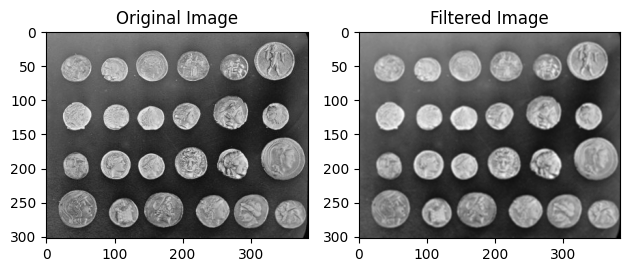

In [5]:
# Load an example image from scikit-image
image = data.coins()

# What is the filter length/width dimension?
filterDimension = 3

# Define a mean filter
mean_filter = np.ones((filterDimension, filterDimension)) / (filterDimension*filterDimension)

# Apply the mean filter to the image using convolution
filtered_image = convolve2d(image, mean_filter, mode='same', boundary='symm')

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(filtered_image, cmap='gray')
ax[1].set_title('Filtered Image')

fig.tight_layout()

Or, we can try to look for edges:

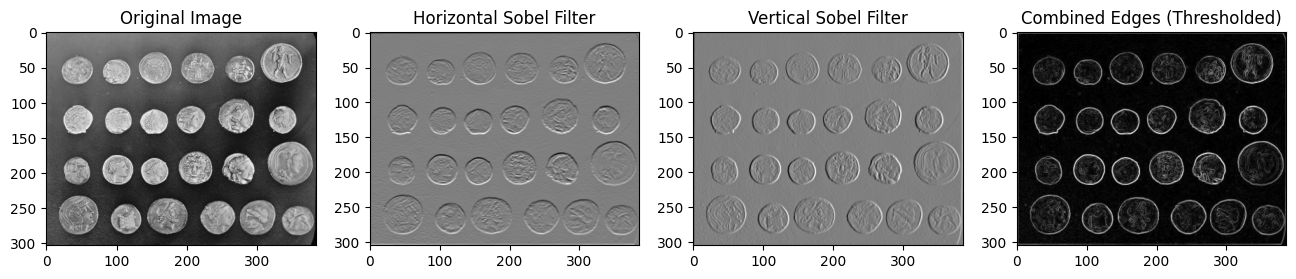

In [6]:
# Sobel filters
sobel_filter_horizontal = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

sobel_filter_vertical = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# Apply the Sobel filters to the image
result_horizontal = convolve2d(image, sobel_filter_horizontal)
result_vertical = convolve2d(image, sobel_filter_vertical)

# Combine the horizontal and vertical edges to get the overall edges
edges = np.sqrt(result_horizontal**2 + result_vertical**2)

# Thresholding to accentuate the edges
threshold = 10
edges[edges < threshold] = 0

# Display the original, horizontal Sobel, vertical Sobel, and combined edge images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(result_horizontal, cmap='gray')
axes[1].set_title('Horizontal Sobel Filter')

axes[2].imshow(result_vertical, cmap='gray')
axes[2].set_title('Vertical Sobel Filter')

axes[3].imshow(edges, cmap='gray')
axes[3].set_title('Combined Edges (Thresholded)')

plt.show()

## 1.3 Assembling a CNN

The architecture of a CNN classically comprises:

1. A **convolutional** layer
2. An **activation** layer
3. A **pooling** layer
4. A **fully connected** layer

### 1.3.1 The convolutional layer

*Note that here we will consider a CNN that takes in images and returns some output*

Aspects of this layer:

**Inputs**: In the case of 2D convolutions, three dimensions: *height, width, depth.* 

**Filters**: The actual convolutional kernels, with have a bias of 1 and weights for each element of the kernel. The output of these filters is a **filter map**. Generally, the number of filters is greater than the input depth. The **kernel size** often is square, but does not need to be. 

**Stride**: The step size by which the filter moves. 

**Padding**: Values that are added to the edges of the input.

![Convolution Kernel](https://d2l.ai/_images/correlation.svg)

*Convolution with kernel window (Fig. 6.2.1 from Dive into Deep Learning).*

In the example above, we perform the following operation: the top-left output value is = 0×0+1×1+3×2+4×3=19. Then we repeat the process until all elements of the output map are filled. We also repeat this for each filter.

<sub>*A great lecture about CNN is one done at Stanford, [CS230](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks).*</sub>

So, how might you interpret the following code?

In [7]:
# pytorch version
torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=6)

Conv2d(3, 64, kernel_size=(6, 6), stride=(1, 1))

### 1.3.2 The activation layer

The convolutional layer is followed by an activation layer. This layer applies an *activation function*, such as **ReLU (Rectified Linear Unit)**, to the outputs of the convoution. 

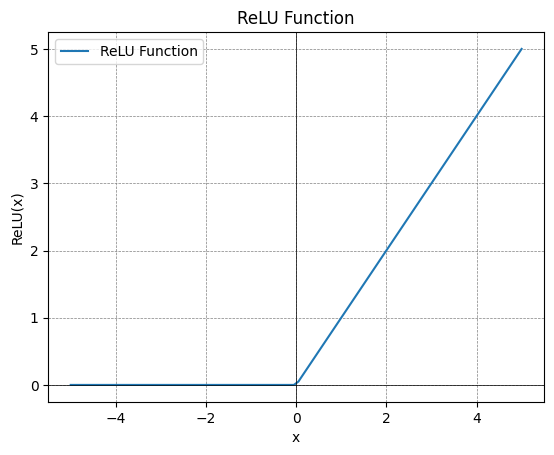

In [29]:
# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Generate x values
x = np.linspace(-5, 5, 100)

# Apply the ReLU function to x
y_relu = relu(x)

# Create figure and axis
fig, ax = plt.subplots()

# Plot the ReLU function
ax.plot(x, y_relu, label='ReLU Function')
ax.set_title('ReLU Function')
ax.set_xlabel('x')
ax.set_ylabel('ReLU(x)')
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.legend()

# Show the plot
plt.show()

### 1.3.3 The pooling layer

The pooling layer allows us to *downsample* our feature maps. In general, by combining values, pooling reduces the complexity and size of models. It is not the only strategy for doing so. 

**Max pooling** layers work by taking the maximum value within a given neighborhood (dictated by *the pooling size*).

![](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/pooling.svg)


### 1.3.4 The fully connected layer

Finally, we include a fully connected layer (where every input is connected to every output) in our model. Often, CNNs utilize a **softmax** layer to transform the outputs of a fully connected layer into probabilities (i.e., values between 0 and 1). 

### 1.3.5 Some notes

In the convolutional layer, the neurons are not connected to every part of the input data.

A dense layer learns global patterns. A convolution layer learns local patterns. Because of that, CNNs are **translation invariant** as they pick part of the image of time series and generalize the learning elsewhere. CNNs learn **hierarchical patterns**: a first layer learns a local pattern, a second layer combines the local features to create a broader scale feature.





## 2.0 Let's practice with a CNN!

We will create a CNN LeNet architecture (LeCun et al, 1998) to classify images from the fashion MNIST data. We will write it in Keras/Tensorflow and in PyTorch.

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits,fetch_openml
from sklearn.preprocessing import StandardScaler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import transforms, ToTensor, Compose,Normalize
from sklearn.model_selection import train_test_split
from torchvision import datasets
import os

dataset = datasets.MNIST(root="./",download=True,
 transform=Compose([ToTensor(),Normalize([0.5],[0.5])]))
L=len(dataset)
# Training set
Lt = int(0.8*L)

train_set, val_set = torch.utils.data.random_split(dataset, [Lt,L-Lt])
loaded_train = DataLoader(train_set, batch_size=50)
loaded_test = DataLoader(val_set, batch_size=50)
print(loaded_train)

X, y = next(iter(loaded_train))
print(X.shape)

torch.Size([50, 1, 28, 28])


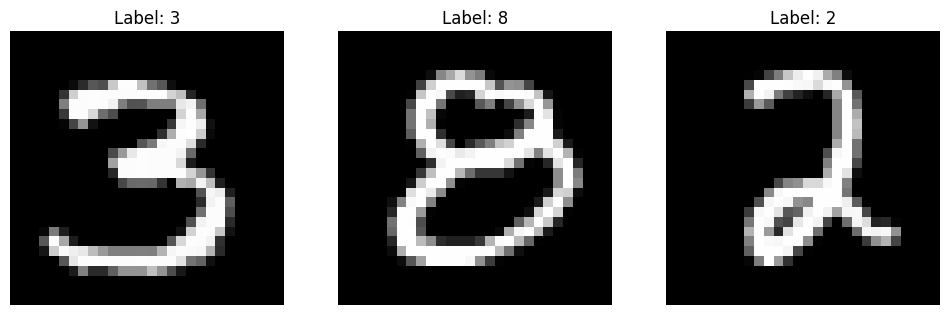

In [38]:
# Display 3 images
num_images_to_display = 3

# Set up a subplot
fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))

for i in range(num_images_to_display):
    # Get a random batch
    images, labels = next(iter(loaded_train))
    
    # Display the image
    img = images[i].numpy().squeeze()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()

### 2.1 Our model of choice

We will create a CNN LeNet-5 architecture (LeCun et al, 1998) that is a sequential stack of 3 convolutional layers, 2 fully connected layers. There are several graphical representations of networks that we often find in the literature, such as:

![](https://d2l.ai/_images/lenet.svg)

In [ ]:
# Implementation in Keras
# model = keras.Sequential([
# # Must define the input shape in the first layer of the neural network
# keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='sigmoid', input_shape=(28,28,1)),
# keras.layers.AveragePooling2D(2), # you could replace with MaxPooling2D
# keras.layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='sigmoid'),
# keras.layers.AveragePooling2D(2),# you could replace with MaxPooling2D
# keras.layers.Flatten(),
# keras.layers.Dense(120, activation='sigmoid'),
# # keras.layers.Dropout(0.5),
# keras.layers.Dense(84, activation='sigmoid'),
# # keras.layers.Dropout(0.5),
# keras.layers.Dense(10, activation='softmax')])
# # Take a look at the model summary
# model.summary()

### 2.2 A LeNet-5 implementation in pytorch

In [39]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

In [22]:
model_lenet= torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5,
                                               padding=2), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

In [23]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
print('Initial input shape: \t', X.shape)
for layer in model_lenet:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Initial input shape: 	 torch.Size([1, 1, 28, 28])
Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


#### 2.2.1 We start by defining some training parameters

We need to choose some training parameters, including:

* The error metric: accuracy
* Our loss function: *cross-entropy* for multiclassification
* The batch size
* How many epochs (iterations)
* Which optimizer we would like to use (in this case, *Adam*, which is a modified version of stochastic gradient descent that leverages estimations of the first and second moments of the gradient to adapt the learning rate for each weight)


In [42]:
alpha = 0.005# learning rate lr
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=alpha)
# Set fixed random number seed
torch.manual_seed(42);

#### 2.2.2 We then train the model
As part of our training, we will plot the accuracy scores as a function of epochs.

In [26]:
def train(model, n_epochs, trainloader, testloader=None,learning_rate=0.001 ):

    os.makedirs('lenet_checkpoint',exist_ok=True)
    # Define loss and optimization method
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)

    # # Loop on number of epochs
    for epoch in range(n_epochs):
    #     # Initialize the loss
        running_loss = 0
    #     # Loop on samples in train set
        for data in trainloader:
    #         # Get the sample and modify the format for PyTorch
            inputs, labels = data[0], data[1]
            inputs = inputs.float()
            labels = labels.long()
    #         # Set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    #         # Propagate the loss backward
            loss.backward()
    #         # Update the gradients
            optimizer.step()
    #         # Add the value of the loss for this sample
            running_loss += loss.item()
    #     # Save loss at the end of each epoch
        loss_time[epoch] = running_loss/len(trainloader)

        
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
                        }
        
        f_path = './lenet_checkpoint/checkpoint.pt'
        torch.save(checkpoint, f_path)
        

        
    #     # After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
    #         # We evaluate the model, so we do not need the gradient
            with torch.no_grad(): # Context-manager that disabled gradient calculation.
    #             # Loop on samples in test set
                for data in testloader:
    #                 # Get the sample and modify the format for PyTorch
                    inputs, labels = data[0], data[1]
                    inputs = inputs.float() 
                    labels = labels.long()
    #                 # Use model for sample in the test set
                    outputs = model(inputs)
    #                 # Compare predicted label and true label
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
    #         # Save error at the end of each epochs
            accuracy_time[epoch] = 100 * correct / total
    
    #     # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
              (epoch + 1, running_loss/len(trainloader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader)))

    # # Save history of loss and test error
    if testloader is not None:
        return (loss_time, accuracy_time)
    else:
        return (loss_time)
        

In [27]:
(loss, accuracy) = train(model_lenet, 3,loaded_train, loaded_test)

[Epoch 1] loss: 0.936 - accuracy: 92.133
[Epoch 2] loss: 0.212 - accuracy: 95.517
[Epoch 3] loss: 0.134 - accuracy: 96.867


3


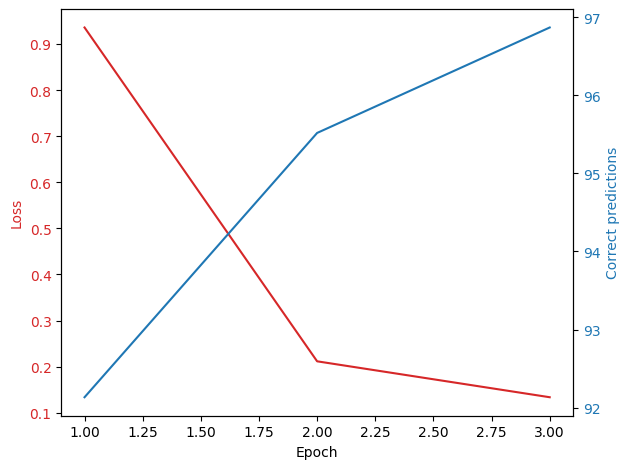

In [28]:
fig, ax1 = plt.subplots()
print(len(loss))
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, len(loss)+1), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, len(accuracy)+1), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## 3. Example on seismic data

In this class, we will use a simplified version of ConvNetQuake (Perol et al, 2018). The network was designed as a classification algorithm that detects seismic events and assigns their location in spatial clusters. The earthquakes from a previously known earthquake catalog were clustered using k-means. We will use the two seismic station seismograms already labeled as "earthquakes" or "noise" to perform.

![ConvNetQuake](../img/ConvNetQuake.jpg)
<!-- <img src="figures/ConvNetQuake.jpg" alt="ConvNetQuake" style="width: 400px;"/> -->

### 3.1 read the data
Download the data and place it in a "data" folder.

In [ ]:
import wget
wget.downloads("https://www.dropbox.com/s/vi9gmjy8d4zd5jv/templates_029.h5?dl=1")
os.replace("templates_029.h5", "../../data/templates_029.h5")

In [ ]:
# load OK029 template data:
with h5py.File("../../data/templates_029.h5", "r") as f:
    eq1 = np.asarray(f['earthquakes']);neq1=eq1.shape[0]
    no1 = np.asarray(f["noise"])


# # load OK027 template data:
# with h5py.File("./data/templates_027.h5", "r") as f:
#     eq2 = np.asarray(f['earthquakes'])
#     no2 = np.asarray(f["noise"])

### 3.2 Prep the data

In [ ]:
#  allocate memory
quakes=np.zeros(shape=(eq1.shape[0],1000,3),dtype=np.float32)
noise=np.zeros(shape=(no1.shape[0],1000,3),dtype=np.float32)
# quakes2=np.zeros(shape=(eq2.shape[0],1000,3),dtype=np.float32)
# noise2=np.zeros(shape=(no2.shape[0],1000,3),dtype=np.float32)

# Normalize the seismograms to their peak amplitudes
for iq in range(eq1.shape[0]):
    for ic in range(3):
        if np.max(np.abs(eq1[iq,ic,:]))>0:
            quakes[iq,:,ic]=eq1[iq,ic,:]/np.max(np.abs(eq1[iq,ic,:]))
            
for iq in range(no1.shape[0]):
    for ic in range(3):
        if np.max(np.abs(no1[iq,ic,:]))>0:
            noise[iq,:,ic]=no1[iq,ic,:]/np.max(np.abs(no1[iq,ic,:]))

# for iq in range(eq2.shape[0]):
#     for ic in range(3):
#         if np.max(np.abs(eq2[iq,ic,:]))>0:
#             quakes2[iq,:,ic]=eq2[iq,ic,:]/np.max(np.abs(eq2[iq,ic,:]))
            
# for iq in range(no12.shape[0]):
#     for ic in range(3):
#         if np.max(np.abs(no2[iq,ic,:]))>0:
#             noise2[iq,:,ic]=no2[iq,ic,:]/np.max(np.abs(no2[iq,ic,:]))

# select data that is strictly positive and finite
iq1=np.where( ( np.abs(quakes[:,0,0])>0)&(np.isfinite(quakes[:,0,0])))[0]
# iq2=np.where( (np.abs(quakes2[:,0,0])>0)&(np.isfinite(quakes2[:,0,0])))[0]

In [ ]:
# label & data
y = np.concatenate((np.ones(len(iq1)+len(iq2),dtype=np.int),np.zeros(len(iq1)+len(iq2),dtype=np.int))) # 0 for noise, 1 for event
# X = np.zeros(shape=(len(train_labels),1000,3,1))
X= np.concatenate((quakes[iq1,:,:],quakes2[iq2,:,:],noise[iq1,:,:],noise2[iq2,:,:]),axis=0)
X=X[...,None]# add that depth/channel dimension

nlabels=2 # = len(np.unique(y))

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

### 3.3 Define ML model
ConvNetQuake is a simple stack of 8 conv2d layers with 32 channels, stride of 2 kernel size of 3x3, ReLu activation functions, padding is the same

In [ ]:
# write model training function

In [ ]:
# train the model

In [ ]:
# plot the learning curve

In [ ]:
# test the model

## 4. How to read and recode published networks

Let us say that you read a research paper explaining the architecture of the convolutional neural network used by the authors to carry out their data analysis. How will you try to reproduce their results? They do not provide a github!

Let us look at the following paper:

Rouet-Leduc, B., Hulbert, C., McBrearty, I. W., Johnson, P. A. (2020). Probing slow earthquakes with deep learning. Geophysical Research Letters, 47, e2019GL085870. [https://doi.org/10.1029/2019GL085870](https://doi.org/10.1029/2019GL085870).

![CNN RouetLeDuc 2020](https://agupubs.onlinelibrary.wiley.com/cms/asset/42274df7-7069-40c1-bda1-fdbf6891f358/grl60169-fig-0001-m.jpg)
<!-- <img src="figures/cnn_rouet-leduc.png" width="600"> -->
Schematic of the CNN and its architecture (Figure 1 from Rouet-Leduc et al. (2020)

* **Batch Normalization** => unclear from the paper, but this seems to be the normalization of the data
* **Dropout** => unclear from the paper what this is
* **Input** Spectrogram = Image with 129 x 95 x1 pixels
* **Conv2D** convolution is has a kernel size of 16x16 feature map of size 114x80 is depth 32 (# of channels), activation is ReLU (found in the supplementary material)
* **Maxpooling** of size 2
* **Dropout** 5%, found in the supplementary material
* **Conv2D** of kernel size 8 x 8, depth 64
* **Maxpooling** of size 2
* **Dropout** 5%, found in the supplementary material
* **Full Connected - Dense layers** with 36608 neurons (found in the supplementary material)
* **Full Connected - Dense layers** with 10 neurons (found in the supplementary material)
* **Full Connected - Dense layers** with 1 neuron, sigmoid activation function (found in the supplementary material)

## 5. Tuning CNN networks

There are many hyperparameters and model choices to make:
* training: learning rate, optimizer, batch_size, loss functions, regularization
* architecture: number of layers, depth of kernels, activation functions, batch normalization

One can treat the hyperparameter search as an optimization problem. In fact, there is an entire research field about **Network Architecture Search**. One can implement this by performing a **grid search** over the model architecture hyperparameter and picking the best performing model.

Keras tuner (https://keras-team.github.io/keras-tuner/) can be used to randomize the grid search.

<!-- http://caffe.berkeleyvision.org/model_zoo.html -->

In [43]:
model = torch.nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=16),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Dropout(0.05),
                            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=8),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Dropout(0.05),
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4),
                            nn.Flatten(),
                            nn.Linear(36608, 10),
                            nn.Sigmoid(),
                            nn.Linear(10, 1),
                            nn.Sigmoid())